In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fetch BMW stock data from Yahoo Finance
bmw_stock = yf.download('BMW.DE', start='2018-01-01', end='2023-01-01')

# Use the 'Close' prices for prediction
data = bmw_stock.filter(['Close']).values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create training and testing datasets
seq_length = 60  # Sequence length for LSTM

# Prepare the training data
train_data = scaled_data[:1500]  # 1500 days as training data
x_train, y_train = [], []
for i in range(seq_length, len(train_data)):
    x_train.append(train_data[i - seq_length:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  # Reshape for LSTM

# Prepare the testing data
test_data = scaled_data[200 - seq_length:]  # Use remaining data as testing data
x_test, y_test = [], []
for i in range(seq_length, len(test_data)):
    x_test.append(test_data[i - seq_length:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape for LSTM

[*********************100%%**********************]  1 of 1 completed


In [57]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [58]:
# Compile the model with accuracy as a metric
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')



In [59]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=50, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])



38/38 [==============================] - 7s 44ms/step - loss: 0.0436 - val_loss: 0.0063
Epoch 2/50
38/38 [==============================] - 1s 15ms/step - loss: 0.0085 - val_loss: 0.0052
Epoch 3/50
38/38 [==============================] - 1s 16ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 4/50
38/38 [==============================] - 1s 14ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 5/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 6/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 7/50
38/38 [==============================] - 1s 20ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 8/50
38/38 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 9/50
38/38 [==============================] - 1s 15ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 10/50
38/38 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 11/50
38/38 [=

In [60]:
# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Loss: {loss}")


34/34 [==============================] - 0s 7ms/step - loss: 0.0010
Loss: 0.0010292563820257783


In [61]:
# Make predictions
predictions = model.predict(x_test)

34/34 [==============================] - 1s 6ms/step


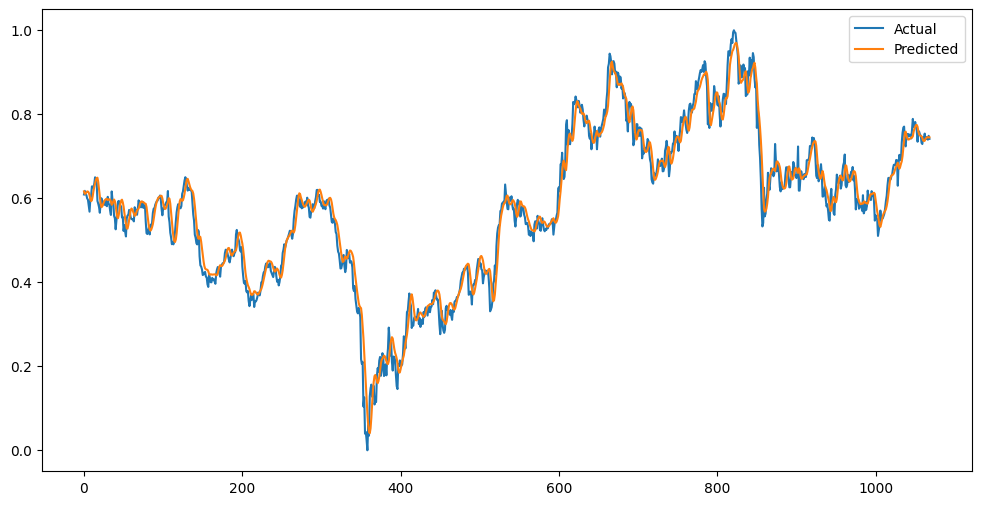

In [62]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [63]:
# Convert predictions to binary classes (1: increase, 0: decrease or stay the same)
binary_predictions = np.zeros_like(predictions)
binary_predictions[1:] = np.where(predictions[1:] > predictions[:-1], 1, 0)

# Convert test data to binary classes
binary_actual = np.zeros_like(y_test)
binary_actual[1:] = np.where(y_test[1:] > y_test[:-1], 1, 0)

# Create Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(binary_actual, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[239 296]
 [250 284]]


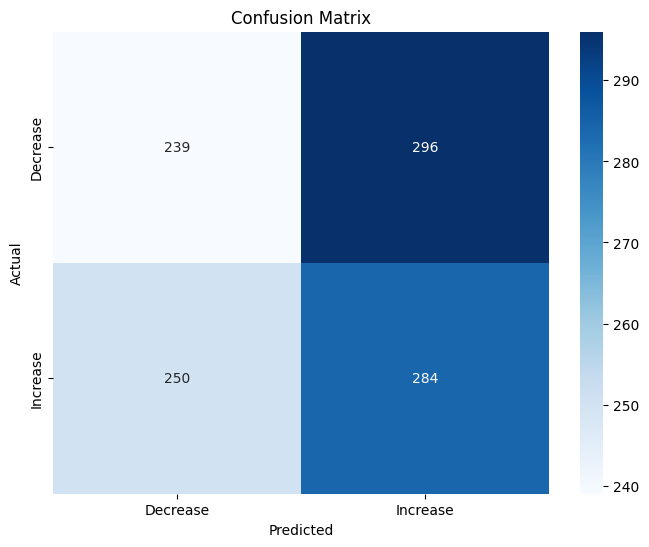

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [65]:
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
FN = conf_matrix[1, 0]  # False Negatives
TP = conf_matrix[1, 1]  # True Positives

# Calculate Recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy:", accuracy)

# Calculate Precision
precision = TP / (TP + FP)
print("Precision:", precision)

Recall: 0.5318352059925093
Accuracy: 0.4892422825070159
Precision: 0.4896551724137931


**model2**

In [ ]:
from keras.layers import BatchNormalization  # Adding BatchNormalization

# Define the LSTM model with changes in optimizer and loss function
model2 = Sequential()
model2.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.3))
model2.add(LSTM(units=32))
model2.add(Dropout(0.3))
model2.add(Dense(units=1))

# Adding BatchNormalization layers
model2.add(BatchNormalization())

# Compile the model with a different optimizer and loss function
from keras.optimizers import RMSprop  # Trying a different optimizer
optimizer = RMSprop(learning_rate=0.001)  # Adjust learning rate if needed
model2.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error loss

# Train the model with early stopping
history = model2.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

# Make predictions and assess performance as before
# ...


In [44]:
# Evaluate the model2
loss = model2.evaluate(x_test, y_test)
print(f"Loss: {loss}")

34/34 [==============================] - 0s 5ms/step - loss: 0.0011
Loss: 0.001085833297111094


In [45]:
# Make predictions
predictions2 = model2.predict(x_test)

34/34 [==============================] - 1s 4ms/step


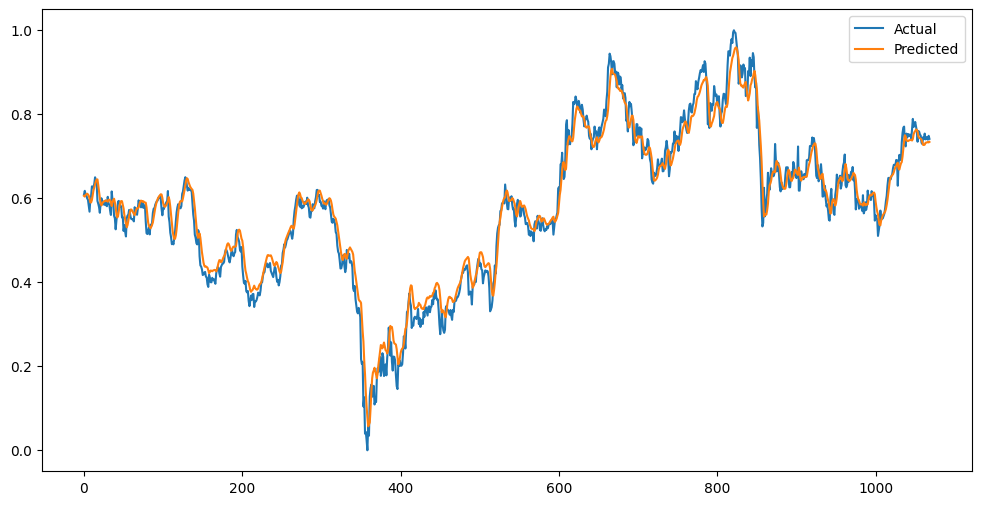

In [46]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.show()


In [47]:

binary_predictions = np.zeros_like(predictions2)
binary_predictions[1:] = np.where(predictions2[1:] > predictions2[:-1], 1, 0)



conf_matrix2 = confusion_matrix(binary_actual, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[242 293]
 [249 285]]


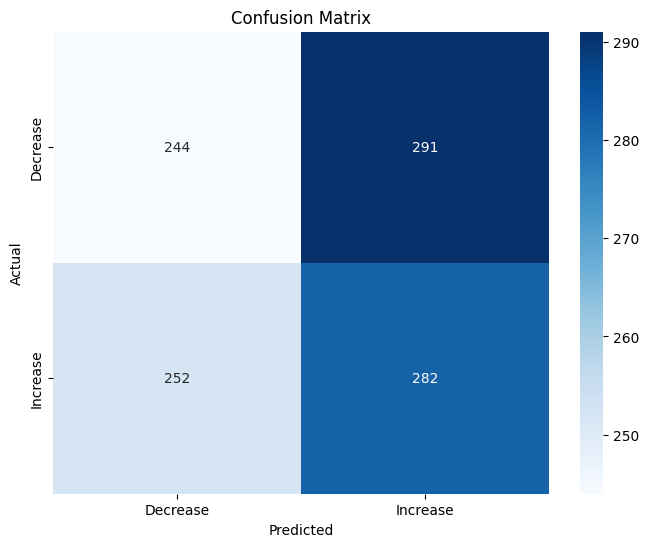

In [48]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [49]:
TN = conf_matrix2[0, 0]  # True Negatives
FP = conf_matrix2[0, 1]  # False Positives
FN = conf_matrix2[1, 0]  # False Negatives
TP = conf_matrix2[1, 1]  # True Positives

# Calculate Recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy:", accuracy)

# Calculate Precision
precision = TP / (TP + FP)
print("Precision:", precision)

Recall: 0.5280898876404494
Accuracy: 0.4920486435921422
Precision: 0.49214659685863876


#### Model 3

In [ ]:
#model 3
from keras.layers import Conv1D, MaxPooling1D, Flatten  # Introducing 1D Convolutional Layers

model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(units=64, return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(units=32))
model3.add(Dropout(0.5))
model3.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping
history = model3.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

# Make predictions and assess performance as before
# ...


In [17]:
# Evaluate the model3
loss = model3.evaluate(x_test, y_test)
print(f"Loss: {loss}")

34/34 [==============================] - 0s 5ms/step - loss: 0.0022
Loss: 0.0022355106193572283


In [19]:
# Make predictions
predictions3 = model3.predict(x_test)

34/34 [==============================] - 0s 8ms/step


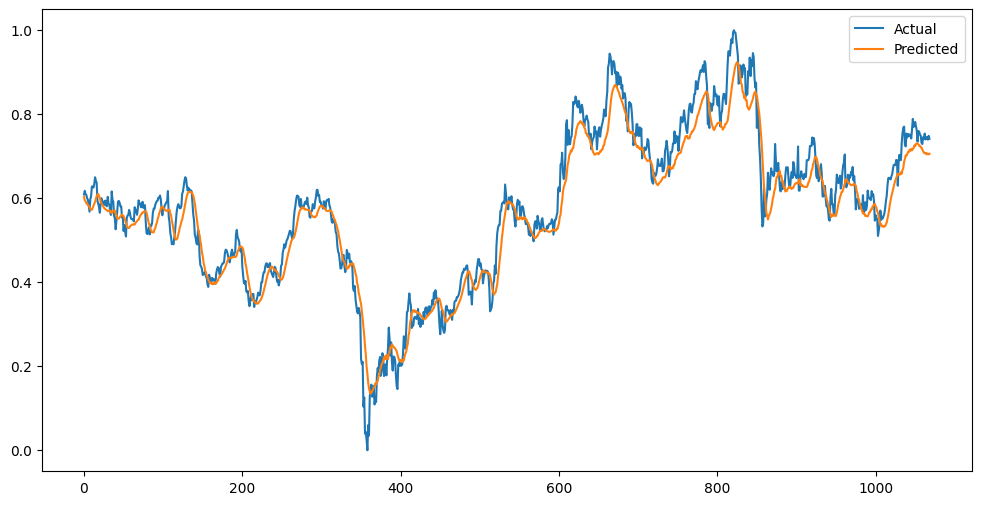

In [20]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(predictions3, label='Predicted')
plt.legend()
plt.show()


In [22]:
# Convert predictions to binary classes (1: increase, 0: decrease or stay the same)
binary_predictions = np.zeros_like(predictions3)
binary_predictions[1:] = np.where(predictions[1:] > predictions[:-1], 1, 0)

# Convert test data to binary classes
binary_actual = np.zeros_like(y_test)
binary_actual[1:] = np.where(y_test[1:] > y_test[:-1], 1, 0)

# Create Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix3 = confusion_matrix(binary_actual, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix3)


Confusion Matrix:
[[250 285]
 [250 284]]


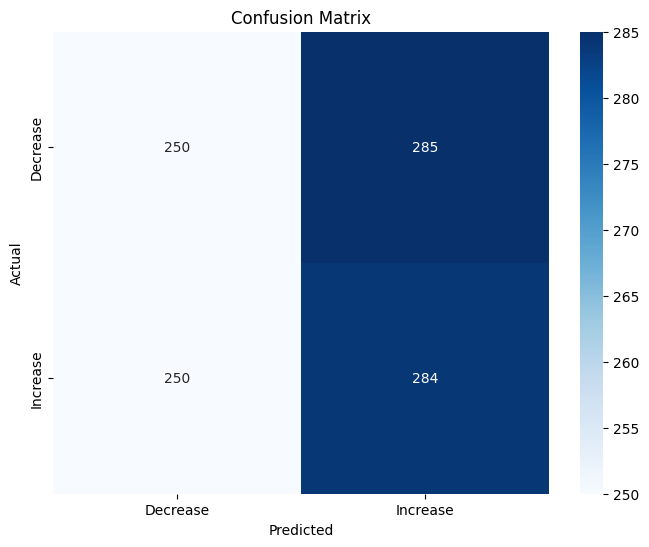

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
TN = conf_matrix3[0, 0]  # True Negatives
FP = conf_matrix3[0, 1]  # False Positives
FN = conf_matrix3[1, 0]  # False Negatives
TP = conf_matrix3[1, 1]  # True Positives

# Calculate Recall
recall = TP / (TP + FN)
print("Recall:", recall)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy:", accuracy)

# Calculate Precision
precision = TP / (TP + FP)
print("Precision:", precision)

Recall: 0.5318352059925093
Accuracy: 0.49953227315247895
Precision: 0.4991212653778559
